In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import CHILDES_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
transcript_df = pd.read_pickle(CHILDES_DFS/'childes_df_subset.pickle')
#transcript_df['dataset'] = [i[0].split('/')[11] for i in transcript_df.transcript_xml.values]
len(transcript_df)

2785

In [5]:
# mask for only a subset of corpuses
possible_corpuses = [
    # carterette is also transcribed in IPA
    "Carterette",  # 1st, 3rd, 5th grade, adults, speech naturalistic speech in IPA https://childes.talkbank.org/access/Eng-NA/Carterette.html
    "Gillam",  # normal subset, spontaneous storytelling 5-11y11m https://childes.talkbank.org/access/Clinical-MOR/Gillam.html
    "Braunwald",  # single subject from 1-6yo talking to family https://childes.talkbank.org/access/Eng-NA/Braunwald.html
    "Brown",  # 1y6m-5y1m, 3 subjects naturalistic talking to parents https://childes.talkbank.org/access/Eng-NA/Brown.html
    "EllisWeismer",  # 2y6m - 5y6 naturalistic play-oriented talk with instructor # https://childes.talkbank.org/access/Clinical-MOR/EllisWeismer.html
    "Gleason",  # 2;1 - 5;2 family interactions https://childes.talkbank.org/access/Eng-NA/Gleason.html
    "NH",# Nicholas-NH,  # 1;0-4;0, videotaped play with parent https://childes.talkbank.org/access/Clinical-MOR/Nicholas/NH.html
    "Post",  # 1;7-2;8 60m session with family and toys https://childes.talkbank.org/access/Eng-NA/Post.html
    "Normal",  #  Rondal-Normal 3-12yo free play with mother and child https://childes.talkbank.org/access/Clinical-MOR/Normal /Normal.html
]
corpus_mask = [corpus in possible_corpuses for corpus in transcript_df.corpus.values]
transcript_df = transcript_df[corpus_mask]

In [6]:
# mask for a subset of roles
possible_roles = ['Target_Child', 'Child']
role_mask = [role in possible_roles for role in transcript_df.role.values]
transcript_df = transcript_df[role_mask]
len(transcript_df)

2785

In [7]:
#transcript_df.to_pickle(CHILDES_DFS/'childes_df_subset.pickle')

In [8]:
transcript_df[:3]

,PID,lang,corpus,date,participant_key,role,age,language,sex,POS,words,morphemes,transcript_xml,n_words,n_morphemes,n_POS,age_months,age_years
72301,11312/c-00015848-1,eng,Carterette,1984-01-01,CHI,Target_Child,P6Y,eng,NaN,"[[pro:per, v, , , conj, n:prop, coord, pro:ind...","[[you, mean, uh, um, like, England, or, someth...","[[you, mean, uh, um, like, England, or, someth...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,19903,2102,2102,72.0,6.0
72302,11312/c-00015847-1,eng,Carterette,1984-01-01,CHI,Target_Child,P10Y,eng,NaN,"[[co, , pro:sub, v, , det:num, n], [coord, , p...","[[well, um, I, have, uh, one, sister], [and, u...","[[well, um, I, have, uh, one, sister], [and, u...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,26941,2729,2729,120.0,10.0
72303,11312/c-00015849-1,eng,Carterette,1984-01-01,CHI,Target_Child,P8Y,eng,NaN,"[[v, n, n], [co, n:prop, v, prep, det:art, n, ...","[[lets, watch, tv], [well, Nancy, said, for, t...","[[let-3S, watch, tv], [well, Nancy, say-PAST, ...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,21419,2019,2019,96.0,8.0


In [9]:
transcript_df.iloc[0]

PID                                               11312/c-00015848-1
lang                                                             eng
corpus                                                    Carterette
date                                                      1984-01-01
participant_key                                                  CHI
role                                                    Target_Child
age                                                              P6Y
language                                                         eng
sex                                                              NaN
POS                [[pro:per, v, , , conj, n:prop, coord, pro:ind...
words              [[you, mean, uh, um, like, England, or, someth...
morphemes          [[you, mean, uh, um, like, England, or, someth...
transcript_xml     [/mnt/cube/tsainbur/Projects/github_repos/chil...
n_words                                                        19903
n_morphemes                       

In [10]:
transcript_df['n_words'] = [len(np.concatenate(i)) if len(i) > 0 else 0 for i in transcript_df.words.values]

In [11]:
print(transcript_df.corpus.unique())

['Carterette' 'Brown' 'Braunwald' 'Post' 'Gleason' 'Normal' 'Gillam'
 'EllisWeismer' 'NH']


In [12]:
print("there are {} words in this dataset".format(np.sum(transcript_df.n_words.values)))

there are 1247296 words in this dataset


### Get child ages

In [13]:
import re
def convert_age(age_year):
    "Caclculate age in months from a string in CHILDES format"
    if age_year[-1] == 'Y':
        age_year += '0'
    m = re.match("P(\d+)Y(\d+)M?(\d?\d?)D?", age_year)
    age_month = int(m.group(1)) * 12 + int(m.group(2))
    try:
        if int(m.group(3)) > 15:
            age_month += 1
    # some corpora don't have age information?
    except ValueError as e:
        pass
    return age_month

In [14]:
transcript_df["age_months"] = [
    convert_age(i) if type(i) == str else np.nan for i in tqdm(transcript_df.age.values)
]

In [15]:
transcript_df["age_years"] = transcript_df["age_months"] / 12

### Sentence lengths

### dataset statistics

In [16]:
age_cohorts = [[1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [17]:

for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    
    cohort_subset = transcript_df[
        (transcript_df.age_months/12 > age_cohort_low) & (transcript_df.age_months/12 <= age_cohort_high)
    ]
    
    cohort_words = [[i for i in list(flatten(row.words)) if i not in [None, 'xxx']] for idx, row in cohort_subset.iterrows()]
    
    n_words = len(np.concatenate(cohort_words))
    n_unique_words = len(np.unique(np.concatenate(cohort_words)))
    
    print(age_cohort_low, age_cohort_high, np.median([len(i) for i in cohort_words]), n_words, n_unique_words)
    #plt.hist([len(i) for i in cohort_words])
    #plt.show()

1 1.5 38.0 15154 1239
1.5 2 98.0 57580 3199
2 2.5 204.0 167722 5363
2.5 3 121.5 110580 4995
3 20 394.0 855307 14410



## MI
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

In [18]:
from childes_mi.information_theory import mutual_information as mi

#### Run MI by age cohort

In [19]:
distances = np.arange(1,101)

In [20]:
def remove_repeats(sequence):
    if len(sequence) == 0:
        return sequence
    a = np.array(sequence[1:])
    b = np.array(sequence[:-1])
    c = [sequence[0]] + list(a[a != b])
    return c

['you', 'mean', 'uh', 'um', 'like']
855307 14410


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:   17.6s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  20 out of  50 | elapsed:   23.5s remaining:   35.3s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:   27.9s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done  42 out of  50 | elapsed:   38.3s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  50 | elapsed:   40.6s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:   40.6s remaining:   24.9s
[Parallel(n_jobs=-1)]: Done  42 out of  50 | elapsed:   40.6s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.2s finished


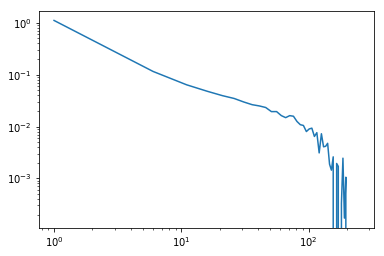

In [21]:
mi_df = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_words",
        "n_unique_words",
        "top_10_words",
        "shuffling"
    ]
)
# for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    
    if age_cohort_low != 3: 
        continue
        
    cohort_subset = transcript_df[
        (transcript_df.age_months / 12 > age_cohort_low)
        & (transcript_df.age_months / 12 <= age_cohort_high)
    ]

    # cohort_words = [[row.PID + "_" + i for i in list(flatten(row.words)) if i not in [None, 'xxx']] for idx, row in cohort_subset.iterrows()]
    cohort_words = [
        [i for i in list(flatten(row.words)) if i not in [None, "xxx"]]
        for idx, row in cohort_subset.iterrows()
    ]
    cwl = np.array([len(i) for i in cohort_words])
    
    print(cohort_words[0][:5])

    n_words = len(np.concatenate(cohort_words))
    n_unique_words = len(np.unique(np.concatenate(cohort_words)))
    print(n_words, n_unique_words)
    # make each phone symbol specific to the transcript
    #for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows()):
    #    cohort_words[transcript_i] = [str(transcript_i) + i for i in cohort_words[transcript_i]]

    n_unique_words = 0
    top_10_words = 0
    
    
    median_n_words = int(np.median([len(i) for i in cohort_words]))
    #distances = np.arange(1, np.max([100, median_n_words]) + 1, 5)
    distances = np.arange(1, 250 + 1, 5)
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_words, distances=distances, n_jobs=-1, estimate=True
    )
    plt.loglog(distances, MI - shuff_MI)
    plt.show()

    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_words,
        n_unique_words,
        top_10_words,
        "full"
    ]
    
  

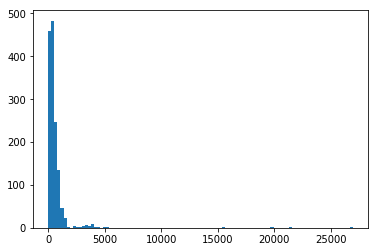

In [22]:
plt.hist(cwl, bins = 100);

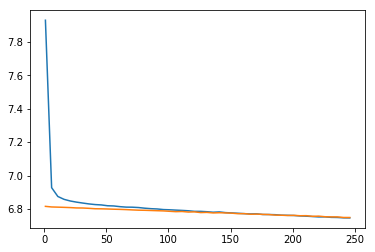

In [23]:
plt.plot(distances, MI)
plt.plot(distances, shuff_MI)

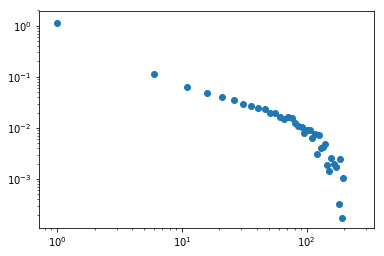

In [24]:
plt.loglog(distances, MI - shuff_MI, alpha = 0)
plt.scatter(distances, MI - shuff_MI)

1434 135
['you', 'mean', 'uh', 'um', 'like']
334404 8756


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 178 out of 200 | elapsed:  1.3min remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.4min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 178 out of 200 | elapsed:  1.3min remaining:    9.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.3min finished


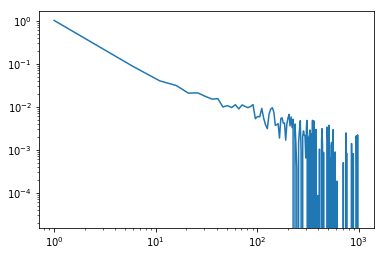

In [47]:
mi_df = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_words",
        "n_unique_words",
        "top_10_words",
        "shuffling"
    ]
)
# for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    
    if age_cohort_low != 3: 
        continue
        
    cohort_subset = transcript_df[
        (transcript_df.age_months / 12 > age_cohort_low)
        & (transcript_df.age_months / 12 <= age_cohort_high)
    ]

    # cohort_words = [[row.PID + "_" + i for i in list(flatten(row.words)) if i not in [None, 'xxx']] for idx, row in cohort_subset.iterrows()]
    cohort_words = [
        [i for i in list(flatten(row.words)) if i not in [None, "xxx"]]
        for idx, row in cohort_subset.iterrows()
    ]
    cwl = np.array([len(i) for i in cohort_words])
    
    cohort_words = [i for i in cohort_words if len(i) > 1000]
    print(len(cwl), len(cohort_words))
    print(cohort_words[0][:5])

    n_words = len(np.concatenate(cohort_words))
    n_unique_words = len(np.unique(np.concatenate(cohort_words)))
    print(n_words, n_unique_words)
    # make each phone symbol specific to the transcript
    #for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows()):
    #    cohort_words[transcript_i] = [str(transcript_i) + i for i in cohort_words[transcript_i]]

    n_unique_words = 0
    top_10_words = 0
    
    
    median_n_words = int(np.median([len(i) for i in cohort_words]))
    #distances = np.arange(1, np.max([100, median_n_words]) + 1, 5)
    distances = np.arange(1, 1000 + 1, 5)
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_words, distances=distances, n_jobs=-1, estimate=True
    )
    plt.loglog(distances, MI - shuff_MI)
    plt.show()

    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_words,
        n_unique_words,
        top_10_words,
        "full"
    ]
    
  

In [29]:
len(cohott_words)

135

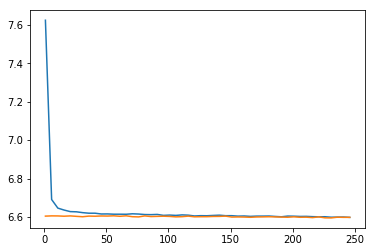

In [30]:
plt.plot(distances, MI)
plt.plot(distances, shuff_MI)

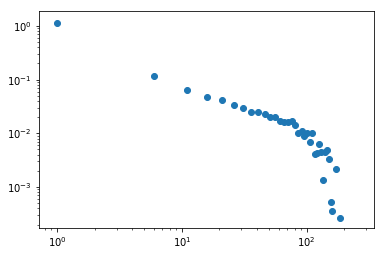

In [23]:
plt.loglog(distances, MI - shuff_MI, alpha = 0)
plt.scatter(distances, MI - shuff_MI)

1434 1289
['you', 'mean', 'uh', 'um', 'like']
847354 14290


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:   23.3s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  20 out of  50 | elapsed:   25.6s remaining:   38.4s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:   27.2s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done  42 out of  50 | elapsed:   39.8s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  20 out of  50 | elapsed:   38.3s remaining:   57.4s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:   38.3s remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  42 out of  50 | elapsed:   38.3s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.3s finished


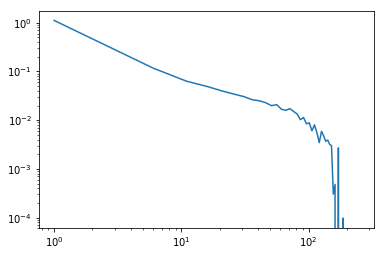

In [31]:
mi_df = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_words",
        "n_unique_words",
        "top_10_words",
        "shuffling"
    ]
)
# for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    
    if age_cohort_low != 3: 
        continue
        
    cohort_subset = transcript_df[
        (transcript_df.age_months / 12 > age_cohort_low)
        & (transcript_df.age_months / 12 <= age_cohort_high)
    ]

    # cohort_words = [[row.PID + "_" + i for i in list(flatten(row.words)) if i not in [None, 'xxx']] for idx, row in cohort_subset.iterrows()]
    cohort_words = [
        [i for i in list(flatten(row.words)) if i not in [None, "xxx"]]
        for idx, row in cohort_subset.iterrows()
    ]
    cwl = np.array([len(i) for i in cohort_words])
    
    cohort_words = [i for i in cohort_words if len(i) > 100]
    print(len(cwl), len(cohort_words))
    print(cohort_words[0][:5])

    n_words = len(np.concatenate(cohort_words))
    n_unique_words = len(np.unique(np.concatenate(cohort_words)))
    print(n_words, n_unique_words)
    # make each phone symbol specific to the transcript
    #for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows()):
    #    cohort_words[transcript_i] = [str(transcript_i) + i for i in cohort_words[transcript_i]]

    n_unique_words = 0
    top_10_words = 0
    
    
    median_n_words = int(np.median([len(i) for i in cohort_words]))
    #distances = np.arange(1, np.max([100, median_n_words]) + 1, 5)
    distances = np.arange(1, 250 + 1, 5)
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_words, distances=distances, n_jobs=-1, estimate=True
    )
    plt.loglog(distances, MI - shuff_MI)
    plt.show()

    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_words,
        n_unique_words,
        top_10_words,
        "full"
    ]
    
  

In [41]:
len(cohort_words)

1289

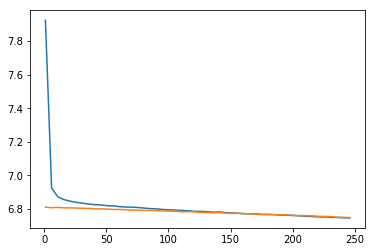

In [39]:
plt.plot(distances, MI)
plt.plot(distances, shuff_MI)

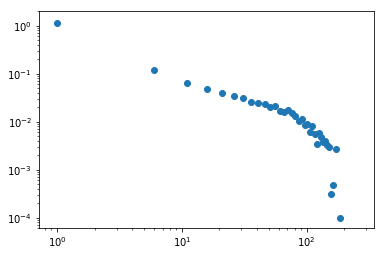

In [40]:
plt.loglog(distances, MI - shuff_MI, alpha = 0)
plt.scatter(distances, MI - shuff_MI)

1434 890
['banana', 'banana', 'big', 'fat', 'yyy']
229589 5207


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    2.8s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  20 out of  50 | elapsed:    5.6s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:    7.9s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  42 out of  50 | elapsed:    9.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  50 | elapsed:    8.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:    8.8s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  42 out of  50 | elapsed:    8.8s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.8s finished


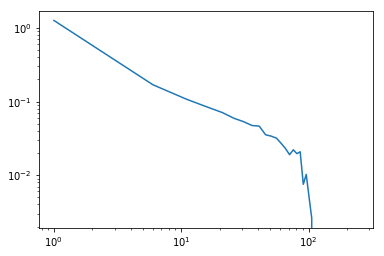

In [42]:
mi_df = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_words",
        "n_unique_words",
        "top_10_words",
        "shuffling"
    ]
)
# for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    
    if age_cohort_low != 3: 
        continue
        
    cohort_subset = transcript_df[
        (transcript_df.age_months / 12 > age_cohort_low)
        & (transcript_df.age_months / 12 <= age_cohort_high)
    ]

    # cohort_words = [[row.PID + "_" + i for i in list(flatten(row.words)) if i not in [None, 'xxx']] for idx, row in cohort_subset.iterrows()]
    cohort_words = [
        [i for i in list(flatten(row.words)) if i not in [None, "xxx"]]
        for idx, row in cohort_subset.iterrows()
    ]
    cwl = np.array([len(i) for i in cohort_words])
    
    cohort_words = [i for i in cohort_words if len(i) < 500]
    print(len(cwl), len(cohort_words))
    print(cohort_words[0][:5])

    n_words = len(np.concatenate(cohort_words))
    n_unique_words = len(np.unique(np.concatenate(cohort_words)))
    print(n_words, n_unique_words)
    # make each phone symbol specific to the transcript
    #for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows()):
    #    cohort_words[transcript_i] = [str(transcript_i) + i for i in cohort_words[transcript_i]]

    n_unique_words = 0
    top_10_words = 0
    
    
    median_n_words = int(np.median([len(i) for i in cohort_words]))
    #distances = np.arange(1, np.max([100, median_n_words]) + 1, 5)
    distances = np.arange(1, 250 + 1, 5)
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_words, distances=distances, n_jobs=-1, estimate=True
    )
    plt.loglog(distances, MI - shuff_MI)
    plt.show()

    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_words,
        n_unique_words,
        top_10_words,
        "full"
    ]
    
  

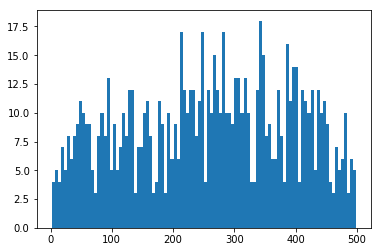

In [46]:
plt.hist([len(i) for i in cohort_words], bins = 100);

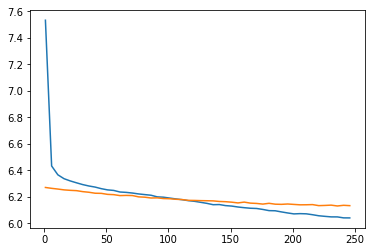

In [44]:
plt.plot(distances, MI)
plt.plot(distances, shuff_MI)

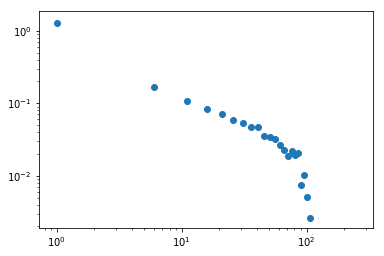

In [45]:
plt.loglog(distances, MI - shuff_MI, alpha = 0)
plt.scatter(distances, MI - shuff_MI)